In [1]:
# !pip install torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
import numpy as np
 
def PCA(X, num_components, return_error=False):
    X_meaned = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_meaned, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]

    eigenvector_subset = sorted_eigenvectors[:, 0:num_components]

    X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    if return_error:
        X_restored = np.dot(X_reduced, eigenvector_subset.transpose()) + np.mean(X, axis=0)
        reconstruction_error = np.mean(np.square(X - X_restored))
        return X_reduced, reconstruction_error
    else:
        return X_reduced

In [4]:
import pandas as pd

df = pd.read_csv("./WineQT.csv")
X = df.iloc[:, :11].values
y = df.iloc[:, 11].values.reshape(-1, 1)
print("Размер обучающего набора:", y.shape[0])

Размер обучающего набора: 1143


In [5]:
from sklearn.preprocessing import StandardScaler
import time

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 
start_time = time.time()
X_pca, pca_error = PCA(X_scaled, 5, return_error=True)
end_time =  time.time()

print("Время расчёта:", end_time - start_time)
print("Ошибка для PCA:", pca_error)

Время расчёта: 0.23270630836486816
Ошибка для PCA: 0.20201911392844002


In [6]:
input_size = X_scaled.shape[1]
hidden_size = 5

autoencoder = Autoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 100
batch_size = 16

X_torch = torch.tensor(X_scaled, dtype=torch.float32)

loss_torch = []
for epoch in range(num_epochs):
    loss_epoch = 0
    for i in range(0, len(X_torch), batch_size):
        batch_x = X_torch[i:i+batch_size]
        output = autoencoder(batch_x)
        loss = criterion(output, batch_x)
        loss_epoch += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_torch.append(loss_epoch) 

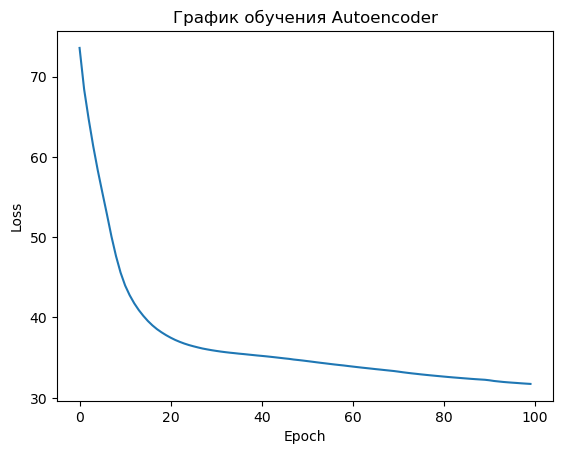

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.arange(num_epochs), loss_torch)
plt.title('График обучения Autoencoder')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
start_time = time.time()
with torch.no_grad():
    X_torch_restored = autoencoder(X_torch).numpy()
end_time = time.time()

print("Время расчёта:", end_time - start_time)
autoencoder_error = np.mean((X_scaled - X_torch_restored) ** 2)
print("Ошибка для автоэнкодера:", autoencoder_error)

Время расчёта: 0.006001949310302734
Ошибка для автоэнкодера: 0.43857613729049194
